In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

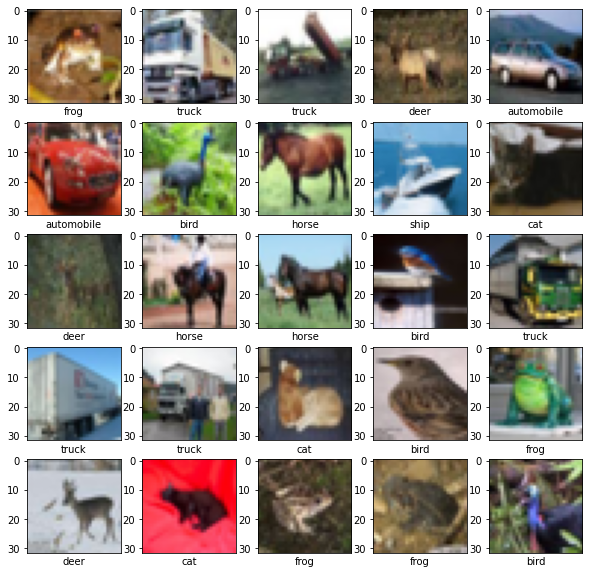

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [4]:
class Autoencoder(Model):
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [5]:
#models
encoding = models.Sequential()
decoding = models.Sequential()

#Encoding layer
encoding.add(layers.Input(shape=(32, 32, 3)))
encoding.add(layers.Conv2D( filters = 64, kernel_size = 3, strides = 2, padding='same', activation='relu')) # 16x16x64
encoding.add(layers.Conv2D( filters = 32, kernel_size = 3, strides = 2, padding='same', activation='relu')) # 8x8x32

#Decoding Layer
decoding.add(layers.Input(shape=(8,8,32)))
decoding.add(layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides=2, activation='relu', padding='same')) # 16x16x32
decoding.add(layers.Conv2DTranspose(filters = 64, kernel_size = 3, strides=2, activation='relu', padding='same')) # 32x32x64
decoding.add(layers.Conv2D(filters = 3, kernel_size = 3, padding='same', activation='sigmoid')) # 32x32x3

encoding = tf.keras.models.load_model('./models/transpose_autoencoder/encoder')
decoding = tf.keras.models.load_model('./models/transpose_autoencoder/decoder')
# autoencoder
autoencoder = Autoencoder(encoding, decoding)

In [6]:
#layers.Conv2DTranspose(filters = 32, kernel_size = 3, strides = 2).compute_output_shape(input_shape=(1,1,1))
autoencoder.compile( loss=tf.keras.losses.MSE, optimizer=tf.keras.optimizers.Adam())

In [7]:
#autoencoder.fit(x = train_images, y = train_images, epochs = 2)

In [8]:
autoencoder.encoder.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 8, 32)          18464     
Total params: 20,256
Trainable params: 20,256
Non-trainable params: 0
_________________________________________________________________


In [9]:
autoencoder.decoder.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_27 (Conv2DT (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 3)         1731      
Total params: 29,475
Trainable params: 29,475
Non-trainable params: 0
_________________________________________________________________


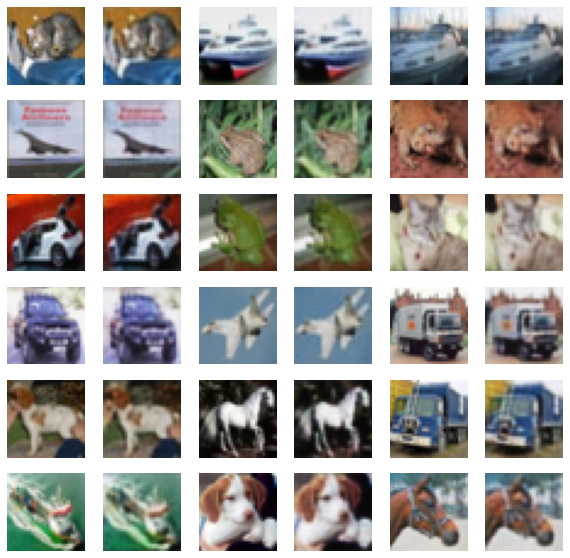

In [10]:
xpred = autoencoder.predict(x=test_images[:25])
fig,axs = plt.subplots(6,6, figsize=(10,10))
for i, ax in enumerate(axs.flat):
    if (i % 2 == 0):
        ax.imshow(test_images[int(i/2)].reshape(32,32,3))
    else:
        ax.imshow(xpred[int(i/2)].reshape(32,32,3))
    ax.axis('off')

In [11]:
feedForward = models.Sequential()

encodedTest = ((autoencoder.encoder(np.expand_dims(train_images[i], axis=0)), train_labels[i]) for i in range(0, len(train_images)))
feedForward.add(layers.Input( shape = (8,8,32)))
feedForward.add(layers.Conv2D( filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
feedForward.add(layers.Flatten())
feedForward.add(layers.Dense(32))
feedForward.add(layers.Dense(10))


feedForward.compile( loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], optimizer=tf.keras.optimizers.Adam())
feedForward.fit(encodedTest, epochs = 5, batch_size = 40, steps_per_epoch = 1250)

Epoch 1/5
1250/1250 [==============================] - 2s 1ms/step - loss: 2.2918 - accuracy: 0.1524
Epoch 2/5
1250/1250 [==============================] - 1s 1ms/step - loss: 2.0617 - accuracy: 0.2875
Epoch 3/5
1250/1250 [==============================] - 1s 1ms/step - loss: 1.9870 - accuracy: 0.2695
Epoch 4/5
1250/1250 [==============================] - 1s 1ms/step - loss: 1.9060 - accuracy: 0.3090
Epoch 5/5
1250/1250 [==============================] - 2s 1ms/step - loss: 1.9161 - accuracy: 0.3073


In [12]:
encodedVal = ((autoencoder.encoder(np.expand_dims(test_images[i], axis=0)), test_labels[i]) for i in range(0, len(test_images)))
test_acc = feedForward.evaluate(encodedVal, verbose = 1)

10000/10000 [==============================] - 12s 1ms/step - loss: 1.8387 - accuracy: 0.3410


In [13]:
#autoencoder.encoder.save(filepath='./models/transpose_autoencoder/encoder')
#autoencoder.decoder.save(filepath='./models/transpose_autoencoder/decoder')